In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# For editable text. 
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_style("whitegrid")
font = {'size' : 6}
lines = {'linewidth' : 0.5}
fig = {'figsize' : (2.5, 1.5)}
mpl.rc('font', **font)
mpl.rc('lines', **lines)
mpl.rc('figure', **fig)

from matplotlib.colors import ListedColormap

# Set style
sns.set(style = "whitegrid", palette = "pastel",
        color_codes=True)

peecolor = "#F7B267"
cmap = ListedColormap(['0.25', 'red'])
colors = ['#0d3b66', '#5fa8d3',  '#ee964b','#f4d35e', '#f95738','#D90368']
sns.color_palette(colors)

from sklearn.decomposition import PCA

import os
os.getcwd()

fsave_path = '../figures/manu_figs/'

#https://github.com/miramou/pe_cfrna/blob/master/analysis/0_QC.ipynb reference

/Users/sevahn/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# pdf save fn
def save_figure_pdf(fig, path_to_save):
	'''
	Utility fxn to save a figure without having to retype all the required options.
	Input:
		fig - a matplotlib.pyplot.figure instance with the figure you'd like to save
		path_to_save - the path you'd like to save the figure to
	Returns: Nothing but there should now be a pdf version in 300 dpi with a transparent bkg at path_to_save
	'''
	fig.savefig(path_to_save, dpi = 300,
                bbox_inches = 'tight', transparent = True)

In [3]:
biofluid_pal = {}

biofluid_pal = {}
biofluid_pal['sediment'] = "#97D9E1"
biofluid_pal['supt'] = "#3F9ED9"
biofluid_pal['plasma'] = "#1F5B9E"
biofluid_pal['normal'] = "#0077be"
biofluid_pal['stone'] = "#34B7D3" # "#F9D71C"
biofluid_pal['bioivt'] = '#5fa8d3'

colors = ['#0d3b66', '#5fa8d3',  '#ee964b','#f4d35e', '#f95738','#D90368']

biofluid_pal[75] = colors[0]
biofluid_pal[150] = colors[1]

cols = [ "#0077be",  "#97D9E1",  "#ffd000",  "#3F9ED9" ] # "#1E9E9E",
for i, val in enumerate(['normal_sediment', 'normal_supt',
                         'stone_sediment', 'stone_supt']):
    print(val)
    sns.color_palette([cols[i]])
    plt.show()
    biofluid_pal[val] = cols[i]

pass_pal = {}
pass_pal['pass'] = '0.25'
pass_pal['fail'] = 'red'

normal_sediment
normal_supt
stone_sediment
stone_supt


In [4]:
# good QC has the samples passing QC and those that do not
urine_qc = pd.read_csv("../data/rna_seq_cts/urine_qc.csv",
                       index_col = 0,
                       sep = ",")

urine_cts = pd.read_csv("../data/rna_seq_cts/urine_htseq_cts.csv",
                       index_col = (0,1))

In [5]:
urine_cts.shape

(60721, 35)

In [6]:
urine_logcpm = np.log2(urine_cts.div(urine_cts.sum(axis = 0), axis = 1) * 10 ** 6 + 1)

In [7]:
# from moufarrej et al frontiers, relaxed ribo to 0.5 given the plots
ribo = 0.5 
deg = 0.4 
intron = 3

threshDict = {}
threshDict['ribo_frac'] = ribo
threshDict['intron_exon_ratio'] = intron
threshDict['bias_frac'] = deg

In [8]:
failed = urine_qc[(round(urine_qc['ribo_frac'], 1) > ribo) | (round(urine_qc['bias_frac'], 1) > deg) | (round(urine_qc['intron_exon_ratio'], 1) > intron)]
failedSamples = failed.index.tolist()

urine_qc['failed_qc'] = ['fail'  if i in failedSamples else 'pass' for i in urine_qc.index]
urine_qc['type'] = ['sediment' if 'sediment' in i else 'plasma' if 'plasma' in i else 'supt' for i in urine_qc.index]

In [9]:
def plot_cts(cts_data, hue_flag, f_save_name = False):
    pca = PCA(n_components = 2)
    reduced_sequencing_data = pca.fit_transform(cts_data.T)
    pcaRes = pd.DataFrame(data = reduced_sequencing_data)

    pcaRes.columns = ['PCA1', 'PCA2']
    pcaRes['biofluid'] = ['sediment' if 'sed' in i else 'supt' if 'supt' in i else 'plasma' for i in cts_data.columns]
    pcaRes['disease'] = ['normal' if i[0] == 'N' else 'stone' for i in cts_data.columns]
    pcaRes['sample_name'] = cts_data.columns
    pcaRes['disease_biofluid'] =  pcaRes.disease + "_" + pcaRes.biofluid    
   
    
    read_length = [75 if 'repool' in i else 150 for i in cts_data.columns]
    pcaRes['read_length'] = read_length
    
    plt.figure(figsize = (5, 5))

    sns.scatterplot(data = pcaRes,
                    x = 'PCA1', y = 'PCA2',
                   hue = hue_flag,
                    palette = biofluid_pal)
    
    pca1_var = np.round(pca.explained_variance_ratio_[0], 2) * 100
    pca2_var = np.round(pca.explained_variance_ratio_[1], 2) * 100
    
    plt.xlabel(f'PCA 1 {pca1_var}%')
    plt.ylabel(f'PCA 2 {pca2_var}%')
    
    plt.legend(bbox_to_anchor = (1.6, 0.5))
    
    
    #if f_save_name:  
    #    save_figure_pdf(plt, f_save_name)


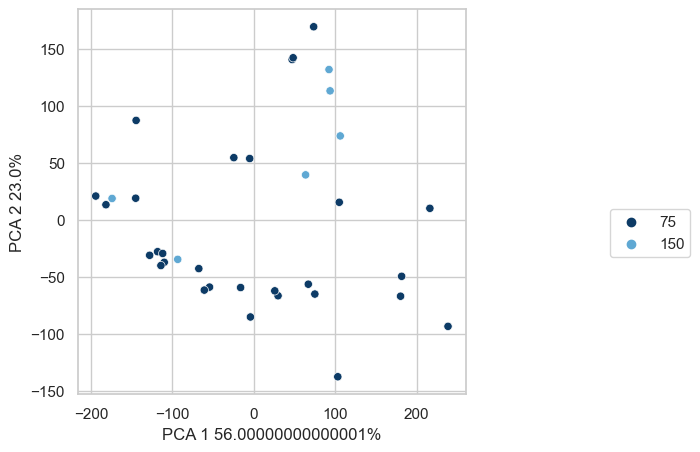

In [10]:
plot_cts(urine_logcpm, 'read_length',
         f_save_name = f"{fsave_path}/pca_unfiltered_readlength.pdf")

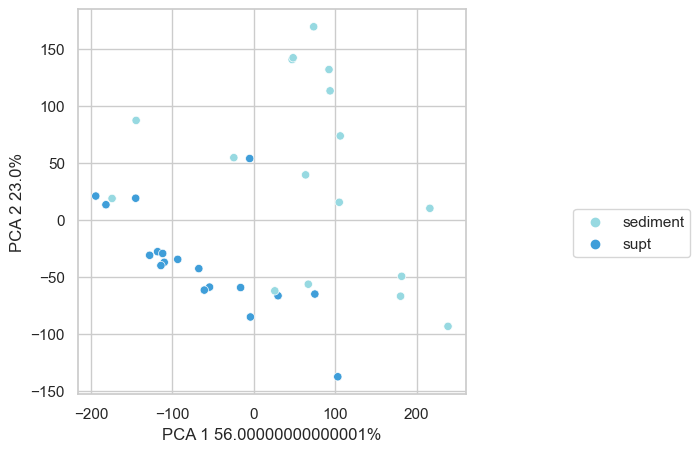

In [11]:
plot_cts(urine_logcpm, 'biofluid',
         f_save_name = f"{fsave_path}pca_unfiltered_sedimentsupt.pdf")

ribo_frac
35
(35, 6)
intron_exon_ratio
35
(35, 7)
bias_frac
35
(35, 8)


/Users/sevahn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sevahn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sevahn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/sevahn/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is depreca

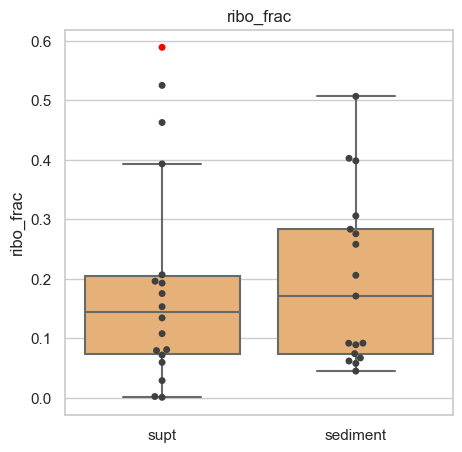

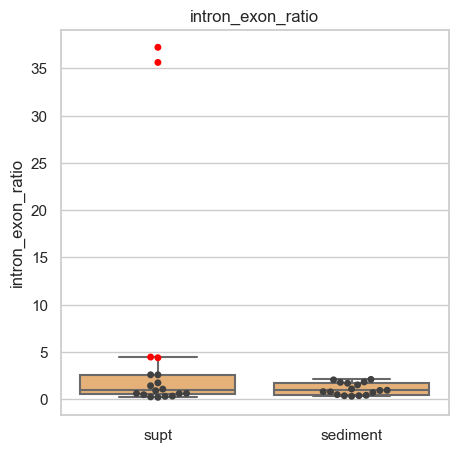

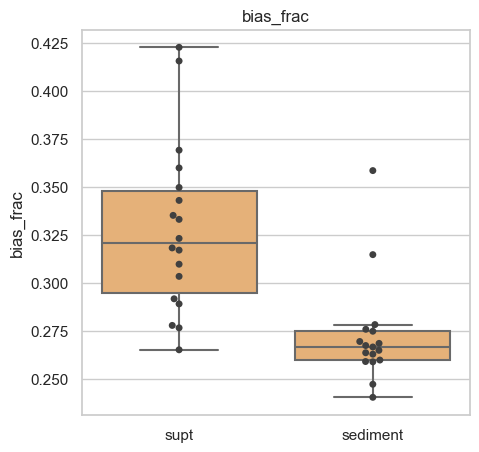

In [12]:
for thresh in threshDict:
    print(thresh)
    threshold = threshDict[thresh]
    plt.figure(figsize = (5, 5))
    
    goodQC_copy = urine_qc
    goodQC_copy[f'fail_{thresh}'] = ['fail' if round(i, 1) > threshold else 'pass' for i in urine_qc[thresh]]
    print(len(np.unique(goodQC_copy[thresh])))
    print(goodQC_copy.shape)
    sns.boxplot(x = 'type',
                y = thresh,
                data = goodQC_copy, 
                order = ['supt', 'sediment'],
                color = peecolor,
                fliersize = 0)
    
    ax = sns.swarmplot(x = 'type',
                       y = thresh,
                       data = goodQC_copy, 
                       size = 5,
                       order = ['supt', 'sediment'],
                       palette = pass_pal,
                       hue = f'fail_{thresh}')

    
    ax.get_legend().set_visible(False)

    plt.title(thresh)
    plt.xlabel("")
    
    
   
    #save_figure_pdf(plt, f'{fsave_path}{thresh}_distribution.pdf')

In [13]:
urine_qc.index = ['N2_sediment' if i == '2_normal_sediment' else i  for i in urine_qc.index]
urine_qc.index = ['N1_sediment' if i == '1_normal_sediment_repool' else i  for i in urine_qc.index]

In [14]:
#urine_qc.to_csv("../data/rna_seq_cts/urine_qc_passing.csv")